# Data processing and EDA

This section includes and overview of the data processing steps performed on the datasets obtained from the ADNI database as well as Exploratory Data Analysis (EDA) to describe key trends in the data and to inform the modeling performed in the later sections of the report.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import io

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

%matplotlib inline

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('axes',labelsize=16)

In [2]:
colors = ["windows blue", "faded green", "greyish", "maroon", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
c3=sns.color_palette()[3]
c4=sns.color_palette()[4]

In [3]:
# ==================================
# Import datta
# ==================================

# Read data
data = pd.read_csv('../data/tadpole/TADPOLE_D1_D2.csv', low_memory=False);

# Create 'year' variable
data['YEAR'] = data['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data_base = data.loc[(data['VISCODE'] == "bl") & (data['ORIGPROT'] == "ADNI1"), :]

In [4]:
# ==================================
# Metadata summary
# ==================================

# Read data
metadata = pd.read_csv("../data/metadata.csv")

df = metadata.groupby('cat').agg({'id': 'count', 'ppn_missing_baseline': 'mean', 'ppn_missing_all': 'mean'})
df.reset_index(inplace=True)
df.ppn_missing_baseline = round(df.ppn_missing_baseline * 100, 1)
df.ppn_missing_all = round(df.ppn_missing_all * 100, 1)

df.columns = ['Category', 'Count', 'Baseline visits', 'All']

## Data processing

### Data sources

The data required for this work were drawn from multiple datasets, all obtained from the website of the Laboratory of Neuro Imaging (LONI) at the University of Southern California (USC). The data sets contained data from all three ADNI studies, but we restricted our usage to only ADNI1. The following datasets 

### Dataset merging & processing

The main dataset (ADNIMERGE), downloaded from the “study data” section, contains observations representing individual visits by subjects. Most columns represent a single biomarker. Some important columns are a unique subject identifier (RID) and visit code (VISCODE), indicating the time of the visit (e.g. baseline, 6 month follow-up, etc.) TADPOLE, a dataset originally created for a data science challenge to forecast future biomarker measurements for individuals in the ADNI study, was also used as a base dataset.

Several other datasets were merged onto the base datasets, such as ADAS cognitive assessment scores (ADASCORES), family history (FHQ), patient demographics (PTEMOG) and genetic markers (TOMM40). In most cases the datasets could be merged using the unique patient identifier and the visit code. Data processing was performed on the merged dataset to make it suitable for further analysis. The data types of all the variables were reviewed and converted to the correct format as required. Categorical variables were one-hot encoded with some grouping applied to levels with a small number of observations. A metadata file was created with descriptive information about each variable in the dataset. The figure below summarizes the number of predictors (shown in brackets) for each biomarker category in the data as well as the proportion of missing observations for each category.

### Feature categories

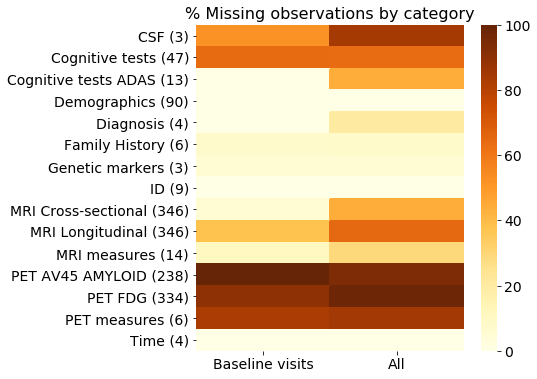

In [5]:
df['Label'] = df.apply(lambda row: row['Category'].replace("(", "").replace(")", "") + " (" + str(row['Count']) + ")", axis=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(df.iloc[:,2:4], yticklabels = list(df.Label), cmap="YlOrBr")
ax.set_title("% Missing observations by category", fontsize=16);

## Exploratory Data Analysis (EDA)

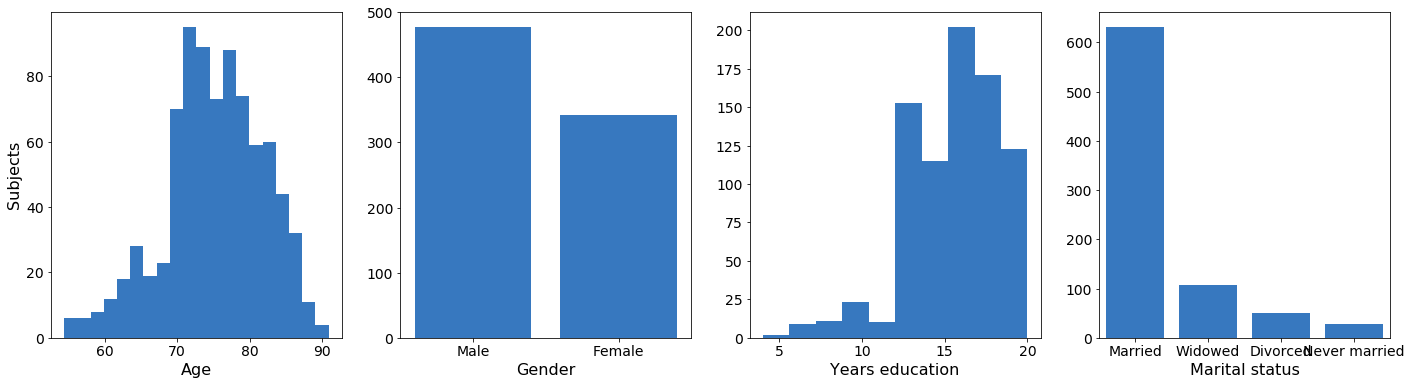

In [6]:
# ==================================
# Demographics (age, gender, education, marital status)
# ==================================

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
ax = axes.ravel()

# Age
ax[0].hist(data_base["AGE"], bins=20, color=c0)
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Subjects")

# Gender
sns.countplot(x="PTGENDER", data=data_base, ax=ax[1], color=c0, saturation=1)
ax[1].set_xlabel("Gender")
ax[1].set_ylabel("")

# Education
ax[2].hist(data_base["PTEDUCAT"], bins=10, color=c0)
ax[2].set_xlabel("Years education")
ax[2].set_ylabel("")

# Gender
df = data_base.loc[data_base.PTMARRY != "Unknown", :]
sns.countplot(x="PTMARRY", data=df, ax=ax[3], color=c0, saturation=1)
ax[3].set_xlabel("Marital status")
ax[3].set_ylabel("");

Our initial data exploration focused on demographics of the participants recruited for the ADNI I phase. As seen above, the majority of participants are married and range between ages 70 and 85, with no participants aged below 55 or above 90. The participants are majority white and male (~40% more males than females), and a significant proportion have some tertiary education. As mentioned on the ADNI website, the study is not population-based and enrolls selected populations who may be used in future treatment trials. The results from ADNI and therefore our analysis may not be generalizable to other populations.

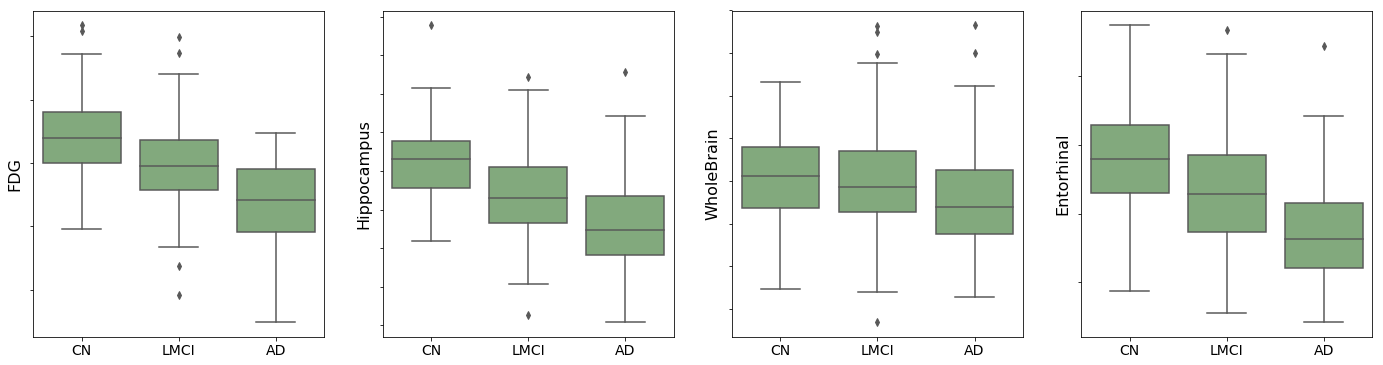

In [7]:
# ==================================
# PET / MRI measures (Boxplots)
# ==================================

cols = ["FDG", "Hippocampus", "WholeBrain", "Entorhinal"]

df = data_base.copy()

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
ax = axes.ravel()

for c in cols:
    i = cols.index(c)
    sns.boxplot(x="DX_bl", y=c, data=df, color=c1, ax=ax[i], order=["CN", "LMCI", "AD"], saturation=0.7, fliersize=5)
    ax[i].set_ylabel(c)
    ax[i].set_xlabel("")
    ax[i].set_yticklabels("")


Cognitive tests are an important measure in diagnosing Alzheimer’s disease, although signs of cognitive decline only become apparent when the disease is well progressed. The relationship between the scores for four cognitive tests and AD diagnosis are shown in the charts above.
* CDRSB (Clinical Dementia Rating Sum of Boxes), ADAS11 (Alzheimer’s Disease Assessment Scale–Cognitive subscale): average scores positively correlated with severity of cognitive impairment  
* MMSE (Mini-Mental State Examination), RAVLT_immediate (Rey Auditory Verbal Learning): average scores negatively correlated with severity of cognitive impairment.


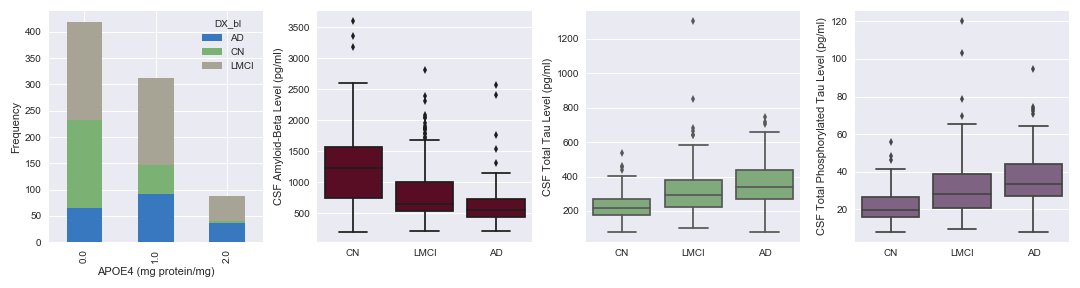

In [8]:
# ==================================
# APOE / CSF (Boxplots)
# ==================================

from IPython.display import Image
fig = Image(filename=('../EDA/images/Biomarkers_levels.png'),width=1700,height=1500)
fig

Protein APOE4 is a known risk factor for AD. In Fig. 3, we can see that the elevated protein levels are prevalent in LMCI and AD patients. Amyloid-Beta, Total Tau and Phosphorylated Total Tau are proteins in the cerebrospinal fluid, which past studies have shown to be associated with AD. From our visualization above, we observe that Amyloid-Beta levels are negatively correlated with AD progression, while the two latter proteins display a positive correlation with AD progression.

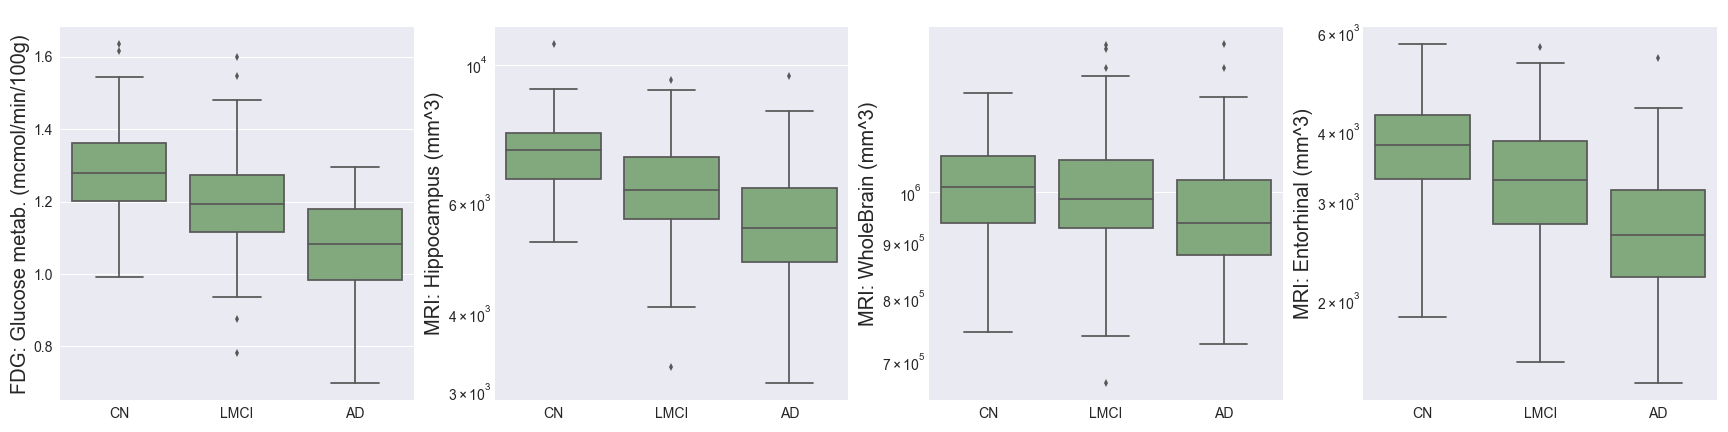

In [9]:
# ==================================
# PET / MRI (Boxplots)
# ==================================

from IPython.display import Image
fig = Image(filename=('../EDA/images/PET_MRI_Boxplots_vol1.png'),width=1700,height=1500)
fig

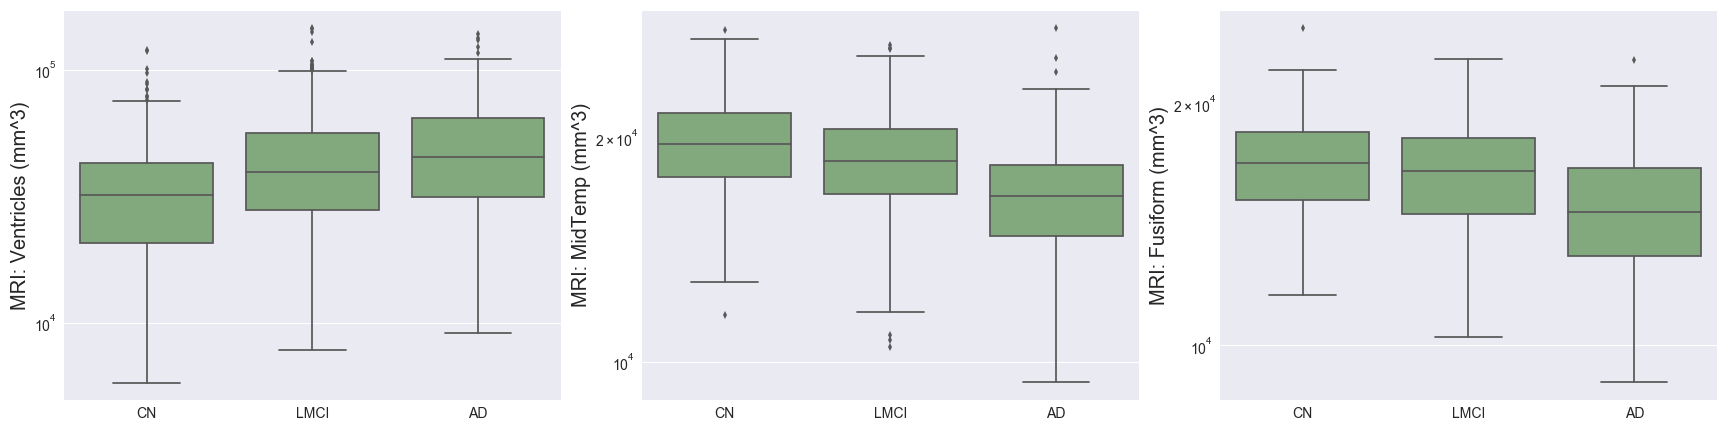

In [10]:
# ==================================
# PET / MRI (Boxplots)
# ==================================

from IPython.display import Image
fig = Image(filename=('../EDA/images/PET_MRI_Boxplots_vol2.png'),width=800,height=200)
fig

Imaging techniques such as MRI and PET measure important brain biomarkers and are used to help make AD diagnoses.
* Fluorodeoxyglucose (FDG) measures cell glucose metabolism and is an indicator of neurodegeneration, obtained from PET scans. We can see above that this decreases as AD progresses.
* Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp, and Ventricles represent volumetric measures of different parts of the brain. The charts above support the hypothesis that AD progression is associated with brain atrophy, in addition to increased brain ventricular volume. The proportional decrease in average entorhinal volume with cognitive impairment is especially marked, and aligns with medical research showing that the entorhinal region is one of the first to be affected by AD.


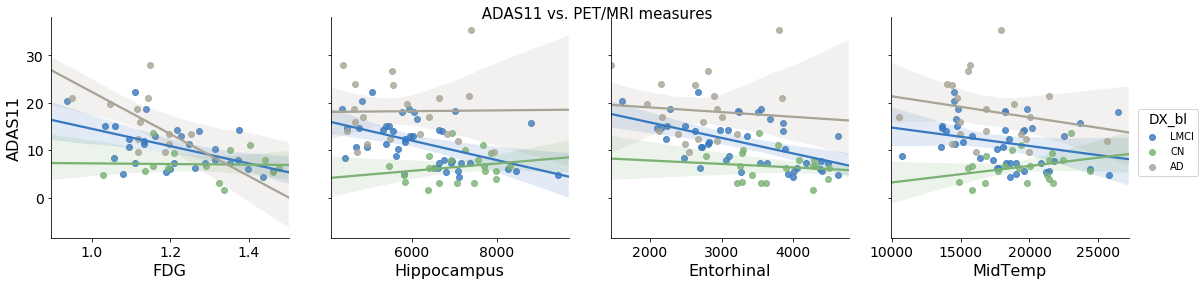

In [11]:
# ==================================
# Colinearity of ADAS11 (cognitive test) with other features
# ==================================

df = data_base.sample(100, random_state=87)
sns.pairplot(df, x_vars=["FDG", "Hippocampus", "Entorhinal", "MidTemp"], y_vars=["ADAS11"], hue="DX_bl", size=4, kind="reg");
plt.suptitle(" ADAS11 vs. PET/MRI measures",fontsize=15);


The ADAS11 cognitive test is collinear with some brain volumetric measures (Hippocampus, Entorhinal, MidTemp) and FDG, and therefore it may be possible to optimize for cost by substituting MRI for PET. Although PET scans are non-invasive and provide useful data, they are expensive and expose the patient to potentially harmful ionizing radiation.

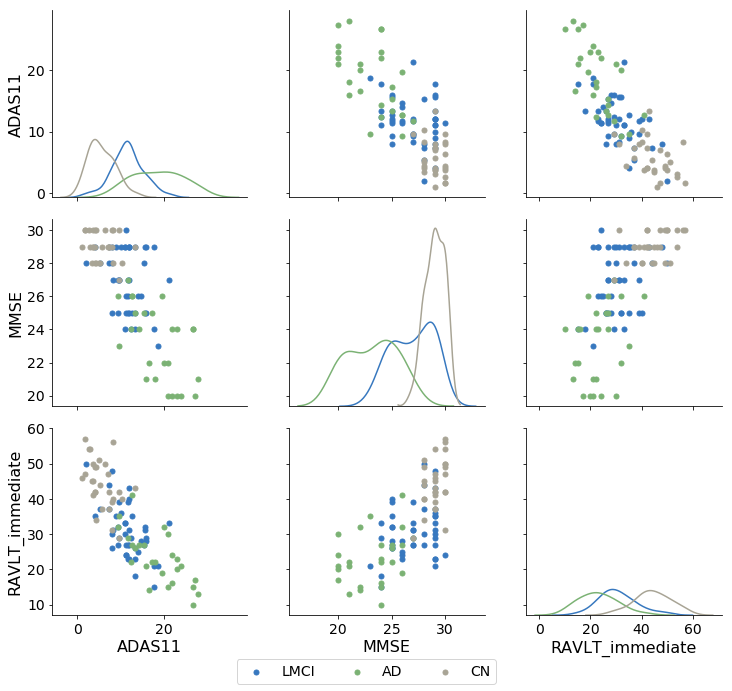

In [12]:
# ==================================
# Cognitive tests (scatter plots)
# ==================================

cols = ["ADAS11", "MMSE", "RAVLT_immediate"]

g = sns.PairGrid(data_base.sample(100, random_state=97), vars=cols, hue="DX_bl", size=3.5)
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter, s=25)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=14)
g.fig.subplots_adjust(top=0.9, bottom=0.1)



From the figure above, we see that the cognitive tests are correlated to a degree (looking at the relationship between ADAS11 & RAVLT, ADAS11 & MMSE as well as RAVLT & MMSE), allowing us to only pick the most time- and cost-effective test in our predictive model.
